## Eoin Moore - Baseball Data Analysis

### Predicting the Next Pitch

The goal of this model is to predict the next pitch a pitcher will use, based on the historical season data up to that point. Our dataset contains detailed, pitch-by-pitch information such as the pitch count, pitch result, which runners are on which bases, and other relevant game dynamics for each pitch. It covers all pitches from the 2011 MLB season. Multiple factors will be considered, including both the pitchers’ and batters’ current and historical performances. We hypothesize that the following factors influence the prediction of the next pitch, and will use feature engineering for these hypotheses:

### Key Factors Influencing Pitch Prediction:
1. **Pitcher’s Season Trends:**
   - How frequently does the pitcher throw different types of pitches (e.g., fastballs, sliders) over the course of the season?
   - This information helps capture the pitcher’s overall style and preferences.

2. **Pitcher’s Current Game Trends:**
   - What has the pitcher been throwing in the current game? For instance, if they are having a strong game with their fastball but struggling with curveballs, this could influence the likelihood of throwing a fastball again.
   - We assess the current performance and adjust the prediction accordingly.

3. **Pitcher’s Outcome Results:**
   - The effectiveness of each pitch in the current game: How likely is a fastball to result in a strike, a play, or a ball? If the pitcher is struggling with a certain pitch, it may influence their decision whether to use it in the next throw.

4. **Batter’s Season Trends:**
   - How often does the batter receive each type of pitch across the season? Some batters may be more familiar with certain pitches and may have better or worse performance based on the pitch type. Coaching staffs may inform their pitchers to pitch to a batter in a particular way. 

5. **Batter’s Current Game Trends:**
   - What is the batter’s current game performance? If a batter is struggling with a certain pitch, the pitcher and coaching staff may adjust the pitch type accordingly to take advantage of weaknesses.

6. **Having Players on Base or Not:**
   - One obvious feature that is not in the database is whether or not a particular base is occupied by a runner. We have three columns in the database that will tell us *which* runner (if any) occupies a base.  I hypothesize that this granularity dilutes the predictive power of this information. We mostly want to know if *someone* is on base, not who. 

### The Approach:
- We will incorporate these *running probabilities* (both pitcher and batter trends) and *base information*  into our dataset to capture the dynamic nature of the game.
- A **gradient boosting model** will be trained on this data to predict the outcome of the next pitch based on these factors.


In [2]:
import matplotlib
from IPython import display
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import pickle
import xgboost as xgb
from scipy.stats import uniform, randint
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import confusion_matrix, log_loss, accuracy_score, classification_report, f1_score
from sklearn.utils.class_weight import compute_class_weight


We first import and clean the data.  There are a number of columns that we will ignore. By sorting on date first, we can then proceed to safely drop those columns.

In [3]:
pitches = pd.read_csv('pitches')
pitches = pitches.sort_values(by = ['year','date','game_pk','at_bat_num', 'pcount_at_bat'])

keep_cols = ['game_pk','pitch_type',  'team_id_b', 'team_id_p', 'inning', 'top', 'at_bat_num', 'pcount_at_bat', 'pcount_pitcher', 'balls', 'strikes', 'fouls', 'outs', 'is_final_pitch', 
              'batter_id', 'stand', 'b_height', 'pitcher_id', 'p_throws', 'away_team_runs', 'home_team_runs', 'score', 'pitch_id', 'type', 
              'type_confidence', 'zone', 'nasty', 'on_1b', 'on_2b', 'on_3b']

pitches = pitches.loc[:,keep_cols]
pitches['b_height']= pitches['b_height'].str.split('-').apply(
    lambda x: int(x[0]) * 12 + int(x[1]))
pitches['b_height'] = pd.to_numeric(pitches['b_height'])
pitches['score'] = pitches['score'].notnull()
pitches['pitch_type'] = pitches['pitch_type'].fillna('XX')


/tmp/ipykernel_366704/1014995016.py:1: DtypeWarning: Columns (29,30) have mixed types. Specify dtype option on import or set low_memory=False.
  pitches = pd.read_csv('pitches')


As I am bit concerned about that previous message, I will look at what columns *29* and *30* are.

In [4]:
pitches.iloc[:,[28,29]] 

,on_2b,on_3b
0,NaN,NaN
1,NaN,NaN
2,NaN,NaN
3,NaN,NaN
4,NaN,NaN
...,...,...
718956,NaN,NaN
718957,NaN,NaN
718958,NaN,NaN
718959,NaN,NaN


It looks like they are just mixed types having because they contain both Numeric and Nan values. We will have to properly convert a number of columns in a few steps. 

Next is the calculation of those running probabilities.

In [4]:
def calc_probabilities(df):
    """
    For each pitch row in df, compute columns reflecting:
      1) Pitcher-level cumulative probabilities (season/game)
         - 'pitcher_season_prob_<pitch_type>'
         - 'pitcher_game_prob_<pitch_type>'
      2) Pitcher-level outcome probabilities (season/game)
         - 'pitcher_season_prob_<pitch_type>_<outcome>'
         - 'pitcher_game_prob_<pitch_type>_<outcome>'
      3) Batter-level cumulative probabilities (season/game)
         - 'batter_season_prob_<pitch_type>'
         - 'batter_game_prob_<pitch_type>'
         (No outcome tracking for batters in this example.)

    The probabilities always exclude the current pitch itself,
    i.e. they come from a group-wise cumsum().shift(1).
    The first pitch in a group defaults to uniform distribution.

    Returns a DataFrame (same shape as df) with added columns.
    """


    # Helper function
    def _calc_probs_for_entity(df_sorted, id_col, prefix, track_outcomes=False):
        """
        df_sorted: DataFrame, already sorted
          Must contain columns:
            [id_col, 'game_pk', 'pitch_type', 'type']
        id_col: 'pitcher_id' or 'batter_id'
        prefix: 'pitcher' or 'batter'
        track_outcomes: True/False to compute pitch_type+outcome counts

        Returns: DataFrame of new columns with index aligned to df_sorted
        """

        # A) Dummy columns for pitch types
        pitch_dummies = pd.get_dummies(df_sorted['pitch_type'], prefix='pt')
        num_pitch_types = pitch_dummies.shape[1]

        # --- Season-level cumulative counts (group by entity) ---
        # cumsum each pitch_type -> shift(1) -> fill first row with 0
        season_cumsums = (
            pitch_dummies
            .groupby(df_sorted[id_col])
            .cumsum()
            .groupby(df_sorted[id_col])
            .shift(1)
        )
        season_cumsums = season_cumsums.fillna(0)

        # total pitches so far (by that entity)
        season_total = season_cumsums.sum(axis=1)

        # probabilities = cumsums / total -> fill with uniform if total=0
        season_probs = season_cumsums.div(season_total.replace(0, np.nan), axis=0)
        season_probs = season_probs.fillna(1.0 / num_pitch_types)

        # rename columns -> prefix+'_season_prob_<pitch_type>'
        rename_map = {}
        for col in season_probs.columns:
            # col is like "pt_FF" -> want "pitcher_season_prob_FF"
            pitch_name = col.replace('pt_', '')
            new_col = f'{prefix}_season_prob_{pitch_name}'
            rename_map[col] = new_col
        season_probs = season_probs.rename(columns=rename_map)

        # Game-level cumulative counts (group by entity+game_pk)
        game_cumsums = (
            pitch_dummies
            .groupby([df_sorted[id_col], df_sorted['game_pk']])
            .cumsum()
            .groupby([df_sorted[id_col], df_sorted['game_pk']])
            .shift(1)
        )
        game_cumsums = game_cumsums.fillna(0)

        game_total = game_cumsums.sum(axis=1)
        game_probs = game_cumsums.div(game_total.replace(0, np.nan), axis=0)
        game_probs = game_probs.fillna(1.0 / num_pitch_types)

        rename_map = {}
        for col in game_probs.columns:
            pitch_name = col.replace('pt_', '')
            new_col = f'{prefix}_game_prob_{pitch_name}'
            rename_map[col] = new_col
        game_probs = game_probs.rename(columns=rename_map)

        # Outcome-based columns (only for pitchers)
        if track_outcomes:
            # Build "pitch_outcome" = "FF_B", "FF_S", etc.
            df_sorted['pitch_outcome'] = df_sorted['pitch_type'] + '_' + df_sorted['type']
            outcome_dummies = pd.get_dummies(df_sorted['pitch_outcome'], prefix='po')
            num_outcomes = outcome_dummies.shape[1]

            # Season-level outcome
            outcome_season_cumsums = (
                outcome_dummies
                .groupby(df_sorted[id_col])
                .cumsum()
                .groupby(df_sorted[id_col])
                .shift(1)
            )
            outcome_season_cumsums = outcome_season_cumsums.fillna(0)

            outcome_season_total = outcome_season_cumsums.sum(axis=1)
            outcome_season_probs = outcome_season_cumsums.div(outcome_season_total.replace(0, np.nan), axis=0)
            # Fill defauly probabilities the uniform probability.  Since there are three possible outcomes, 1/3
            outcome_season_probs = outcome_season_probs.fillna(1/3)

            rename_map = {}
            for col in outcome_season_probs.columns:
                # e.g. col = 'po_FF_B' -> want prefix+'_season_prob_FF_B'
                outcome_name = col.replace('po_', '')
                rename_map[col] = f'{prefix}_season_prob_{outcome_name}'
            outcome_season_probs = outcome_season_probs.rename(columns=rename_map)

            # Game-level outcome
            outcome_game_cumsums = (
                outcome_dummies
                .groupby([df_sorted[id_col], df_sorted['game_pk']])
                .cumsum()
                .groupby([df_sorted[id_col], df_sorted['game_pk']])
                .shift(1)
            )
            outcome_game_cumsums = outcome_game_cumsums.fillna(0)

            outcome_game_total = outcome_game_cumsums.sum(axis=1)
            outcome_game_probs = outcome_game_cumsums.div(outcome_game_total.replace(0, np.nan), axis=0)
            outcome_game_probs = outcome_game_probs.fillna(1/3)

            rename_map = {}
            for col in outcome_game_probs.columns:
                outcome_name = col.replace('po_', '')
                rename_map[col] = f'{prefix}_game_prob_{outcome_name}'
            outcome_game_probs = outcome_game_probs.rename(columns=rename_map)

            # Combine all outcome columns
            outcome_df = pd.concat([outcome_season_probs, outcome_game_probs], axis=1)
        else:
            outcome_df = pd.DataFrame(index=df_sorted.index)

        # Combine pitch-type columns + outcome columns
        combined = pd.concat([season_probs, game_probs, outcome_df], axis=1)
        return combined

    # Use the helper function to build the pitcher columns
    pitcher_cols_df = _calc_probs_for_entity(
        df, id_col='pitcher_id', prefix='pitcher', track_outcomes=True
    )

    # Use the helper function to build the batter columns.
    batter_cols_df = _calc_probs_for_entity(
        df, id_col='batter_id', prefix='batter', track_outcomes=False
    )

    # Concatenate everything
    result = pd.concat([df, pitcher_cols_df, batter_cols_df], axis=1)
    result = result.drop(columns = 'pitch_outcome')
    return result


Let's create a test dataframe and check that this probability calculator works.

In [5]:
test_df = pd.DataFrame({
    'pitcher_id': [
        # Game 1
        1, 1, 1,       # Pitcher 1's first game: FF, FF, CH
        # Game 2
        1, 1,          # Pitcher 1's second game: FF, CH
        # Game 3
        2, 2, 2, 2     # Pitcher 2's game: FF, FF, CH, FF
    ],
    'game_pk': [
        1, 1, 1,       # Game 1
        2, 2,          # Game 2
        3, 3, 3, 3     # Game 3
    ],
    'at_bat_number': [
        1, 2, 3,       # Game 1 at-bats
        1, 2,          # Game 2 at-bats
        1, 2, 3, 4     # Game 3 at-bats
    ],
    'pitch_number': [
        1, 1, 1,       # First pitch of each at-bat
        1, 1,
        1, 1, 1, 1
    ],
    'pitch_type': [
        'FF', 'FF', 'CH',   # Game 1 sequence
        'FF', 'CH',         # Game 2 sequence
        'FF', 'FF', 'CH', 'FF'  # Game 3 sequence
    ],
    'type': [
        'B', 'S', 'B',      # Game 1 results
        'B', 'S',           # Game 2 results
        'S', 'B', 'S', 'B'  # Game 3 results
    ],
    'batter_id': [
        101, 102, 103,      # Game 1 batters
        201, 202,           # Game 2 batters
        301, 302, 303, 304  # Game 3 batters
    ]
})

test_df



,pitcher_id,game_pk,at_bat_number,pitch_number,pitch_type,type,batter_id
0,1,1,1,1,FF,B,101
1,1,1,2,1,FF,S,102
2,1,1,3,1,CH,B,103
3,1,2,1,1,FF,B,201
4,1,2,2,1,CH,S,202
5,2,3,1,1,FF,S,301
6,2,3,2,1,FF,B,302
7,2,3,3,1,CH,S,303
8,2,3,4,1,FF,B,304


In [128]:
result_df = calc_probabilities(test_df)
print(result_df.round(3))


   pitcher_id  game_pk  at_bat_number  pitch_number pitch_type type  batter_id  pitcher_season_prob_CH  pitcher_season_prob_FF  pitcher_game_prob_CH  ...  pitcher_season_prob_FF_B  pitcher_season_prob_FF_S  pitcher_game_prob_CH_B  pitcher_game_prob_CH_S  pitcher_game_prob_FF_B  pitcher_game_prob_FF_S  batter_season_prob_CH  batter_season_prob_FF  batter_game_prob_CH  batter_game_prob_FF
0           1        1              1             1         FF    B        101                   0.500                   0.500                 0.500  ...                     0.333                     0.333                   0.333                   0.333                   0.333                   0.333                    0.5                    0.5                  0.5                  0.5
1           1        1              2             1         FF    S        102                   0.000                   1.000                 0.000  ...                     1.000                     0.000               

This works, and we can justify why.  Look at *pitcher 1*.  He throws, in the first game, *FF*, *FF*, *CH*. In the second, he throws *CH* *FF*.  His cumulative probabilities for *FF* for the season are listed in the ```pitcher_season_prob_FF``` column. The values should be: 
1. **0.5**.   The default is the uniform probability, assuming equal likelihood to all pitches, and there were two pitch types thrown globally. 
2. **1**.   Before throwing the second pitch, all of his pitches were fastballs.
3. **1**.   Same logic as 2.
4. **2/3**.   His third pitch was his first *CH*, so before his fourth pitch, 2/3 pitches had been *FF*.
5. **3/4**.  Similar logic to 4. 

Looking at the game level for the same pitcher, we see that the probability correctly resets with each new game. Within each game, the probability tracks cumulatively.  Similar logic applies to pitch-outcome columns and batter columns. 

Next, lets remind ourselves what the columns in pitches are at this point.

In [94]:
pitches.keys()

Index(['game_pk', 'pitch_type', 'team_id_b', 'team_id_p', 'inning', 'top',
       'at_bat_num', 'pcount_at_bat', 'pcount_pitcher', 'balls', 'strikes',
       'fouls', 'outs', 'is_final_pitch', 'batter_id', 'stand', 'b_height',
       'pitcher_id', 'p_throws', 'away_team_runs', 'home_team_runs', 'score',
       'pitch_id', 'type', 'type_confidence', 'zone', 'nasty', 'on_1b',
       'on_2b', 'on_3b'],
      dtype='object')

In [7]:
pitches_df = calc_probabilities(pitches)
pitches_df

,game_pk,pitch_type,team_id_b,team_id_p,inning,top,at_bat_num,pcount_at_bat,pcount_pitcher,balls,...,batter_game_prob_FT,batter_game_prob_IN,batter_game_prob_KC,batter_game_prob_KN,batter_game_prob_PO,batter_game_prob_SC,batter_game_prob_SI,batter_game_prob_SL,batter_game_prob_UN,batter_game_prob_XX
0,286874,XX,108,118,1,1,1,1,1,0,...,0.052632,0.052632,0.052632,0.052632,0.052632,0.052632,0.052632,0.052632,0.052632,0.052632
1,286874,XX,108,118,1,1,1,2,2,1,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
2,286874,XX,108,118,1,1,1,3,3,2,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
3,286874,XX,108,118,1,1,1,4,4,2,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
4,286874,XX,108,118,1,1,2,1,5,0,...,0.052632,0.052632,0.052632,0.052632,0.052632,0.052632,0.052632,0.052632,0.052632,0.052632
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
718956,317073,FF,140,138,9,1,72,3,7,1,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.076923,0.000000,0.000000,0.000000
718957,317073,FC,140,138,9,1,72,4,8,1,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.071429,0.000000,0.000000,0.000000
718958,317073,FF,140,138,9,1,72,5,9,2,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.066667,0.000000,0.000000,0.000000
718959,317073,FT,140,138,9,1,73,1,10,0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.727273,0.000000,0.000000,0.000000


As one last piece of feature engineering, we are going to track *whether* anyone is on a particular base.  The data currently holds the player id of the person who is on a base in the ```on_1b```, ```on_2b```, ```on_3b``` columns.

In [8]:
pitches_df['on_1b_check'] = ~pd.isna(pitches_df['on_1b'])
pitches_df['on_2b_check'] = ~pd.isna(pitches_df['on_2b'])
pitches_df['on_3b_check'] = ~pd.isna(pitches_df['on_3b'])

Next we convert each column to its requisite type.

In [9]:
int_cols = ['inning', 'pitch_id','away_team_runs', 'home_team_runs', 'at_bat_num', 'pcount_at_bat', 'pcount_pitcher', 'balls', 'strikes', 'fouls', 'outs', 'b_height'] 
float_cols = [col for col in pitches_df.columns if 'prob' in col or col in ['type_confidence', 'nasty']]
bool_cols = ['top', 'is_final_pitch', 'score', 'on_1b_check', 'on_2b_check', 'on_3b_check']
cat_cols = set(pitches_df.columns) - set(int_cols) - set(float_cols) - set(bool_cols)
for col in int_cols:
    pitches_df[col] =pitches_df[col].astype('int64')

for col in float_cols:
    pitches_df[col] = pitches_df[col].astype('float32')
for col in bool_cols:
    pitches_df[col] =pitches_df[col].astype('bool')

for col in cat_cols:
    pitches_df[col] = pitches_df[col].astype('category')

pitches_df = pitches_df.drop(columns ='game_pk')  # we cant use the game Id for predictive power

print(pitches_df.dtypes)

pitch_type             category
team_id_b              category
team_id_p              category
inning                    int64
top                        bool
                         ...   
batter_game_prob_UN     float32
batter_game_prob_XX     float32
on_1b_check                bool
on_2b_check                bool
on_3b_check                bool
Length: 214, dtype: object


We are going to create a number of encoders for the different categorical variables.  All players should share the same Encoder, and this corresponds to all the columns in ```player_values```, and similarly team columns share ```team_values```.

Since we are dealing with temporal data, we must be concerned with data leakage.  For simplicity, I use an 80-20 split, with no shuffling, to prevent data leakage.  We train on the first 80% of the season and test on the last 20%.  This ensures no leakage, however the tradeoff is that we might not capture any trends occurring at the end of the season.  Another approach would have been to use temporal splits.

In [11]:
# First handle player IDs - combine all values
player_values = pd.Series()
player_columns = ['on_1b', 'on_2b', 'on_3b', 'batter_id', 'pitcher_id']
for col in player_columns:
    player_values = pd.concat([player_values, pitches_df[col].astype(str).dropna()])
player_values = player_values.unique()

# Create and fit player encoder
player_encoder = LabelEncoder()
player_encoder.fit(player_values)

# Transform each player column
df_encoded = pitches_df.copy()
for col in player_columns:
    df_encoded[col] = df_encoded[col].astype(str)
    df_encoded[col] = player_encoder.transform(df_encoded[col]).astype(int)
    
# Handle team IDs similarly
team_values = pd.Series()
team_columns = ['team_id_b', 'team_id_p']
for col in team_columns:
    team_values = pd.concat([team_values, pitches_df[col].astype(str).dropna()])
team_values = team_values.unique()

team_encoder = LabelEncoder()
team_encoder.fit(team_values)

for col in team_columns:
    df_encoded[col] = df_encoded[col].astype(str)
    df_encoded[col] = team_encoder.transform(df_encoded[col]).astype(int)

# Handle other categorical columns individually
other_cats = ['p_throws', 'type', 'stand', 'zone']
for col in other_cats:
    encoder = LabelEncoder()
    df_encoded[col] = df_encoded[col].astype(str)
    mask = df_encoded[col].notna()
    values = df_encoded[col][mask].values
    encoder.fit(values)
    df_encoded.loc[mask, col] = encoder.transform(values)
    df_encoded[col] = pd.to_numeric(df_encoded[col], errors='coerce')
    df_encoded[col] = df_encoded[col].fillna(-1)

# Convert boolean columns
bool_cols = ['top', 'is_final_pitch', 'score', 'on_1b_check', 'on_2b_check', 'on_3b_check']
for col in bool_cols:
    df_encoded[col] = df_encoded[col].astype(int)

# # Handle pitch_type encoding for both feature and target
pitch_type_encoder = LabelEncoder()
pitch_type_encoded = pitch_type_encoder.fit_transform(pitches_df['pitch_type'].astype(str))


# Create X and y
X = df_encoded.drop('pitch_type',axis=1)  
y = pitch_type_encoder.fit_transform(pitches_df['pitch_type'].astype(str))

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

I train the model on a GPU cloud instance. This requires installing XGBoost for GPU. 

We let early stopping tell us when to stop.

In [12]:
model = xgb.XGBClassifier(
    objective='multi:softprob',
    eval_metric=['mlogloss', 'merror'],
    n_estimators=1000,
    learning_rate=0.1,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    device='cuda',
    early_stopping_rounds=20
)


# Fit
model.fit(
    X_train, 
    y_train,
    eval_set=[(X_train, y_train), (X_test, y_test)],
    verbose=True  # print eval metrics every 10 rounds
)

[0]	validation_0-mlogloss:2.59063	validation_0-merror:0.44447	validation_1-mlogloss:2.59970	validation_1-merror:0.45492
[1]	validation_0-mlogloss:2.36614	validation_0-merror:0.42405	validation_1-mlogloss:2.37799	validation_1-merror:0.43348
[2]	validation_0-mlogloss:2.20167	validation_0-merror:0.41803	validation_1-mlogloss:2.21510	validation_1-merror:0.42804
[3]	validation_0-mlogloss:2.07085	validation_0-merror:0.41437	validation_1-mlogloss:2.08599	validation_1-merror:0.42396
[4]	validation_0-mlogloss:1.96423	validation_0-merror:0.41242	validation_1-mlogloss:1.98054	validation_1-merror:0.42197
[5]	validation_0-mlogloss:1.86959	validation_0-merror:0.40963	validation_1-mlogloss:1.88696	validation_1-merror:0.41909
[6]	validation_0-mlogloss:1.78757	validation_0-merror:0.40800	validation_1-mlogloss:1.80629	validation_1-merror:0.41796
[7]	validation_0-mlogloss:1.71591	validation_0-merror:0.40680	validation_1-mlogloss:1.73537	validation_1-merror:0.41687
[8]	validation_0-mlogloss:1.65273	valida

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device='cuda', early_stopping_rounds=20,
              enable_categorical=False, eval_metric=['mlogloss', 'merror'],
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=1000,
              n_jobs=None, num_parallel_tree=None, objective='multi:softprob', ...)

Now we have a function that captures several performance metrics. First, we compare the model's accuracy and log loss against several baseline cases:

- **Mode**: Predict the most common pitch.
- **Global Distribution**: Assign each pitch the probability of its global distribution.
- **Previous Pitch**: Use the previous pitch as the prediction for the next.
- **Pitcher-Season**: Choose the pitcher’s most frequent pitch during the season.
- **Pitcher-Game**: Select the pitcher’s most frequent pitch during the current game.
- **Batter-Season**: Use the batter's most common pitch in the season.
- **Batter-Game**: Choose the batter's most frequent pitch in the current game.
- **Random**: A theoretical limit based on random prediction.

*Log loss* is a standard measure of the accuracy of probabilistic predictions, useful in assessing confidences.  Lower log loss is better.

*Accuracy* measures how often the model guesses correctly.  Higher is better.

Additionally, we include feature importance graphs at various granularities to further evaluate model performance.


In [169]:
def visualize_results(model, X_data, y_data, pitch_type_encoder):
    
    # Get the total number of classes and their names from the pitch_type_encoder
    all_classes = list(range(len(pitch_type_encoder.classes_)))
    all_pitches = pitch_type_encoder.classes_  # e.g. 19 pitch types

    # 1) Get model probabilities
    xgb_predictions_prob = model.predict_proba(X_data)
    xgb_predictions = model.predict(X_data)

    # 2) Mode baseline
    most_common = pd.Series(y_train).mode()[0]
    mode_predictions = np.full(len(y_data), most_common)
    mode_prob = np.zeros_like(xgb_predictions_prob)
    mode_prob[:, most_common] = 1

    # 3) Global distribution => convert to label-encoded indices
    global_prob = np.zeros((len(y_data), len(pitch_type_encoder.classes_)))
    for pitch, prob in global_dist.items():
        idx = pitch_type_encoder.transform([pitch])[0]
        global_prob[:, idx] = prob

    # 4) Previous pitch
    prev_pitch_predictions = y_data[:-1]
    prev_prob = np.zeros_like(xgb_predictions_prob[1:])
    for i, pred in enumerate(prev_pitch_predictions):
        prev_prob[i, pred] = 1

    # 5) Probability DataFrames for Pitcher/Batter (game/season), Outcomes (game/season)
    pitcher_game_prob = X_data.filter(like='pitcher_game_prob_')
    pitcher_season_prob = X_data.filter(like='pitcher_season_prob_')
    batter_game_prob = X_data.filter(like='batter_game_prob_')
    batter_season_prob = X_data.filter(like='batter_season_prob_')

    # The outcome probabilities are like pitcher_game_prob_FF_B.  Only these contain five "words", and therefore four underscores.
    outcome_season_prob = X_data.filter(regex=r'^[^_]*_[^_]*_[^_]*_[^_]*_[^_]*$').filter(like='season')
    outcome_game_prob = X_data.filter(regex=r'^[^_]*_[^_]*_[^_]*_[^_]*_[^_]*$').filter(like='game')

    # Build the expected column names for each probability DataFrame
    pitcher_game_cols    = [f'pitcher_game_prob_{pt}' for pt in all_pitches]
    pitcher_season_cols  = [f'pitcher_season_prob_{pt}' for pt in all_pitches]
    batter_game_cols     = [f'batter_game_prob_{pt}' for pt in all_pitches]
    batter_season_cols   = [f'batter_season_prob_{pt}' for pt in all_pitches]

    # Reindex to ensure exactly one column per pitch type, fill missing with 0
    pitcher_game_prob   = pitcher_game_prob.reindex(columns=pitcher_game_cols, fill_value=0.0)
    pitcher_season_prob = pitcher_season_prob.reindex(columns=pitcher_season_cols, fill_value=0.0)
    batter_game_prob    = batter_game_prob.reindex(columns=batter_game_cols, fill_value=0.0)
    batter_season_prob  = batter_season_prob.reindex(columns=batter_season_cols, fill_value=0.0)

    # 6) Evaluate each method
    results = {
        'XGBoost': {
            'accuracy': accuracy_score(y_data, xgb_predictions),
            'log_loss': log_loss(y_data, xgb_predictions_prob, labels=all_classes)
        },
        'Mode Baseline': {
            'accuracy': accuracy_score(y_data, mode_predictions),
            'log_loss': log_loss(y_data, mode_prob, labels=all_classes)
        },
        'Global Distribution': {
            'accuracy': accuracy_score(y_data, global_prob.argmax(axis=1)),
            'log_loss': log_loss(y_data, global_prob, labels=all_classes)
        },
        'Previous Pitch': {
            'accuracy': accuracy_score(y_data[1:], prev_pitch_predictions),
            'log_loss': log_loss(y_data[1:], prev_prob, labels=all_classes)
        },
        'Pitcher-Season': {
            'accuracy': accuracy_score(y_data, pitcher_season_prob.values.argmax(axis=1)),
            'log_loss': log_loss(y_data, pitcher_season_prob, labels=all_classes)
        },
        'Pitcher-Game': {
            'accuracy': accuracy_score(y_data, pitcher_game_prob.values.argmax(axis=1)),
            'log_loss': log_loss(y_data, pitcher_game_prob, labels=all_classes)
        },
        'Batter-Season': {
            'accuracy': accuracy_score(y_data, batter_season_prob.values.argmax(axis=1)),
            'log_loss': log_loss(y_data, batter_season_prob, labels=all_classes)
        },
        'Batter-Game': {
            'accuracy': accuracy_score(y_data, batter_game_prob.values.argmax(axis=1)),
            'log_loss': log_loss(y_data, batter_game_prob, labels=all_classes)
        }

    }


    # Print results
    for method, metrics in results.items():
        print(f"{method}:")
        print(f"Accuracy: {metrics['accuracy']:.4f}")
        print(f"Log Loss: {metrics['log_loss']:.4f}")
        print()
    print(f'Random (theoretical):')
    print('Accuracy: 1/19 = 0.0526')
    print('Log loss: -ln(1/19)= 2.9444')


    # Convert results to DataFrame for easier plotting
    metrics_df = pd.DataFrame(results).T

    # Sort by accuracy (greatest to least) and log loss (least to greatest)
    metrics_df_sorted_by_accuracy = metrics_df.sort_values('accuracy', ascending=False)
    metrics_df_sorted_by_log_loss = metrics_df.sort_values('log_loss', ascending=True)

    # Plot Accuracy
    plt.figure(figsize=(12, 6))
    x = np.arange(len(metrics_df_sorted_by_accuracy))
    plt.bar(x, metrics_df_sorted_by_accuracy['accuracy'], color='skyblue', alpha=0.7)
    plt.xlabel('Model Type')
    plt.ylabel('Accuracy')
    plt.title('Model Accuracy Comparison')
    plt.xticks(x, metrics_df_sorted_by_accuracy.index, rotation=45)
    plt.tight_layout()
    plt.show()

    # Plot Log Loss
    plt.figure(figsize=(12, 6))
    x = np.arange(len(metrics_df_sorted_by_log_loss))
    plt.bar(x, metrics_df_sorted_by_log_loss['log_loss'], color='salmon', alpha=0.7)
    plt.xlabel('Model Type')
    plt.ylabel('Log Loss')
    plt.title('Model Log Loss Comparison')
    plt.xticks(x, metrics_df_sorted_by_log_loss.index, rotation=45)
    plt.tight_layout()
    plt.show()

    # Show top 20 features
    importance = model.feature_importances_
    feature_names = X_train.columns

    n_features = 20
    sorted_idx = importance.argsort()[-n_features:]
    pos = np.arange(n_features) + .5

    plt.figure(figsize=(12, 6))
    plt.barh(pos, importance[sorted_idx])
    plt.yticks(pos, feature_names[sorted_idx])
    plt.xlabel('Feature Importance')
    plt.title(f'Top {n_features} Most Important Features')


    # Feature importance by group
    pitcher_season_cols = [col for col in feature_names if 'pitcher_season' in col]
    pitcher_game_cols = [col for col in feature_names if 'pitcher_game' in col]
    batter_season_cols = [col for col in feature_names if 'batter_season' in col]
    batter_game_cols = [col for col in feature_names if 'batter_game' in col]
    pitch_outcome_cols = set([col for col in feature_names if 'prob' in col])- set(pitcher_season_cols) - set(pitcher_game_cols) - set(batter_season_cols) - set(batter_game_cols)
    other_cols = set(feature_names) - set(pitch_outcome_cols)-set(pitcher_season_cols) - set(pitcher_game_cols) - set(batter_season_cols) - set(batter_game_cols)

    feature_groups = {
        'Pitcher-Season Stats': pitcher_season_cols,
        'Pitcher-Game Stats': pitcher_game_cols,
        'Batter-Season Stats' : batter_season_cols,
        'Batter-Game Stats': batter_game_cols,
        'Pitch type outcomes' : pitch_outcome_cols,
        'Other Stats': list(other_cols)
    }

    # Calculate grouped importance
    grouped_importance = {}
    for group_name, features in feature_groups.items():
        group_importance = sum(importance[feature_names.isin(features)])
        grouped_importance[group_name] = group_importance

    sorted_grouped_importance = dict(sorted(grouped_importance.items(), key=lambda item: item[1], reverse=True))

    #Plot grouped importance

    plt.figure(figsize=(10, 8))
    plt.bar(sorted_grouped_importance.keys(), sorted_grouped_importance.values(), color='teal', alpha=0.7)
    plt.xticks(rotation=45)
    plt.xlabel('Feature Group')
    plt.ylabel('Total Importance')
    plt.title('Feature Importance by Group')
    plt.tight_layout()
    plt.show()


    # Get Other Stats features and their importance
    other_features = list(other_cols)
    other_importance = [importance[feature_names.get_loc(feat)] for feat in other_features]

    # Sort by importance
    other_features_sorted = [x for _, x in sorted(zip(other_importance, other_features), reverse=True)]
    other_importance_sorted = sorted(other_importance, reverse=True)

    # Create bar plot
    plt.figure(figsize=(15, 10))
    plt.barh(range(len(other_importance_sorted)), other_importance_sorted)
    plt.yticks(range(len(other_features_sorted)), other_features_sorted)
    plt.xlabel('Feature Importance')
    plt.title('Feature Importance for Other Stats')

    # Add grid for better readability
    plt.grid(axis='x', linestyle='--', alpha=0.7)

    # Adjust layout to prevent label cutoff
    plt.tight_layout()
    plt.show()    

XGBoost:
Accuracy: 0.6984
Log Loss: 0.7648

Mode Baseline:
Accuracy: 0.3419
Log Loss: 10.4910

Global Distribution:
Accuracy: 0.3419
Log Loss: 20.4420

Previous Pitch:
Accuracy: 0.3772
Log Loss: 9.9296

Pitcher-Season:
Accuracy: 0.4573
Log Loss: 1.3544

Pitcher-Game:
Accuracy: 0.4479
Log Loss: 2.2645

Batter-Season:
Accuracy: 0.3406
Log Loss: 1.9825

Batter-Game:
Accuracy: 0.3312
Log Loss: 4.5313

Random (theoretical):
Accuracy: 1/19 = 0.0526
Log loss: -ln(1/19)= 2.9444


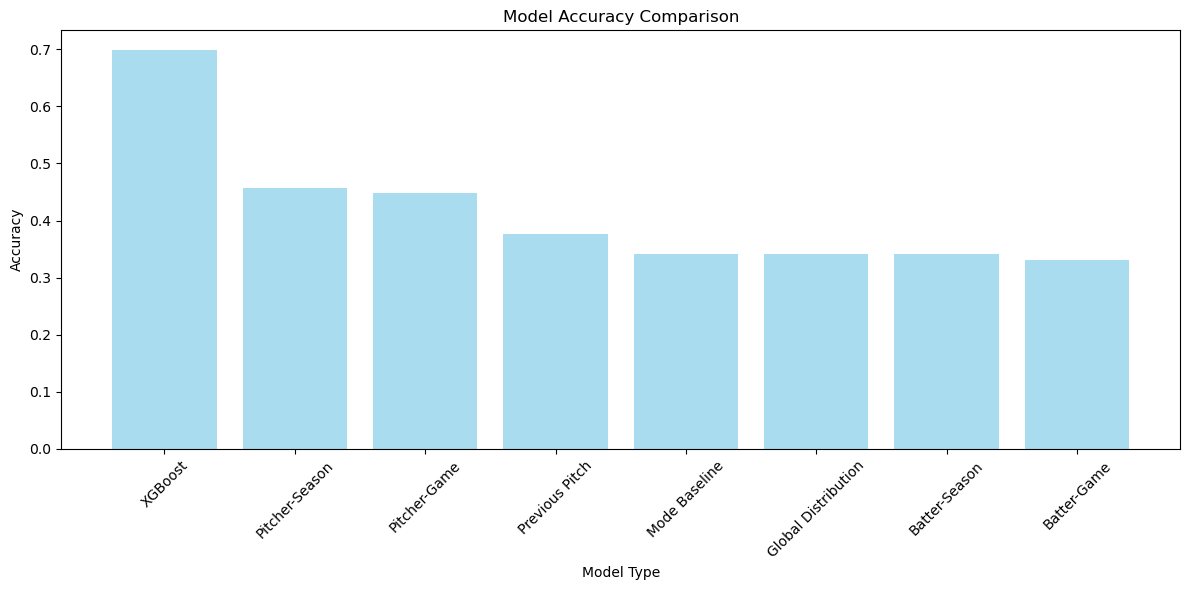

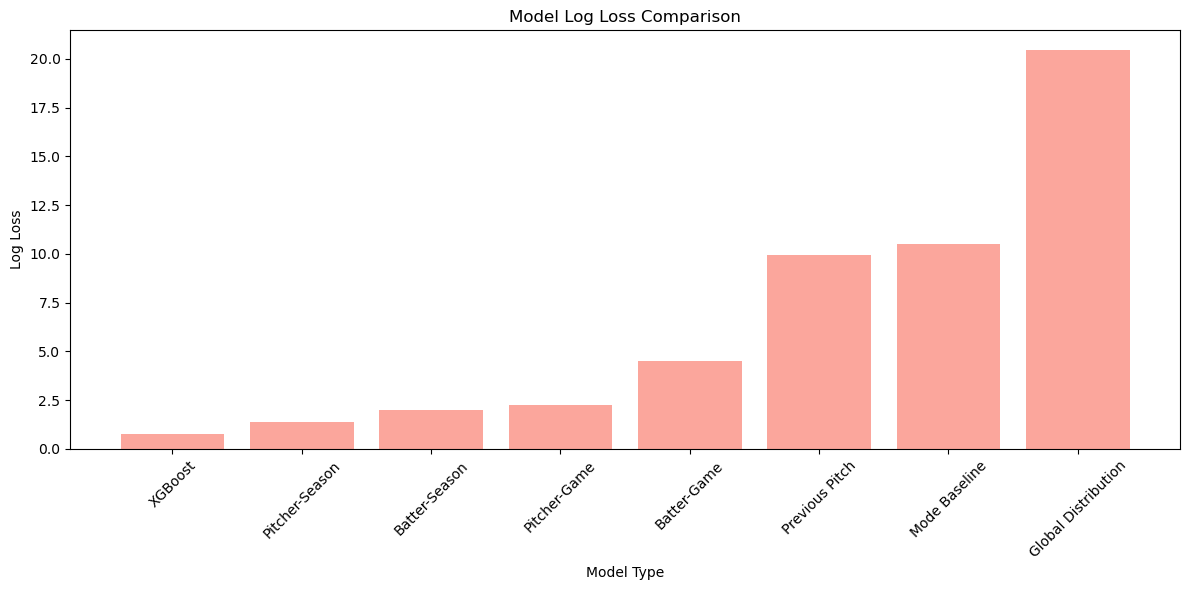

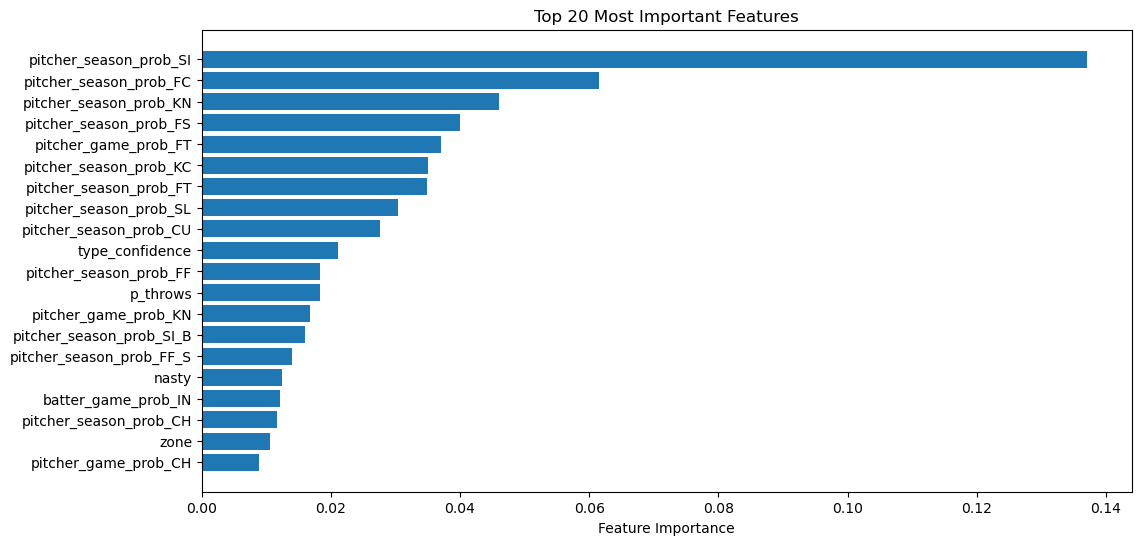

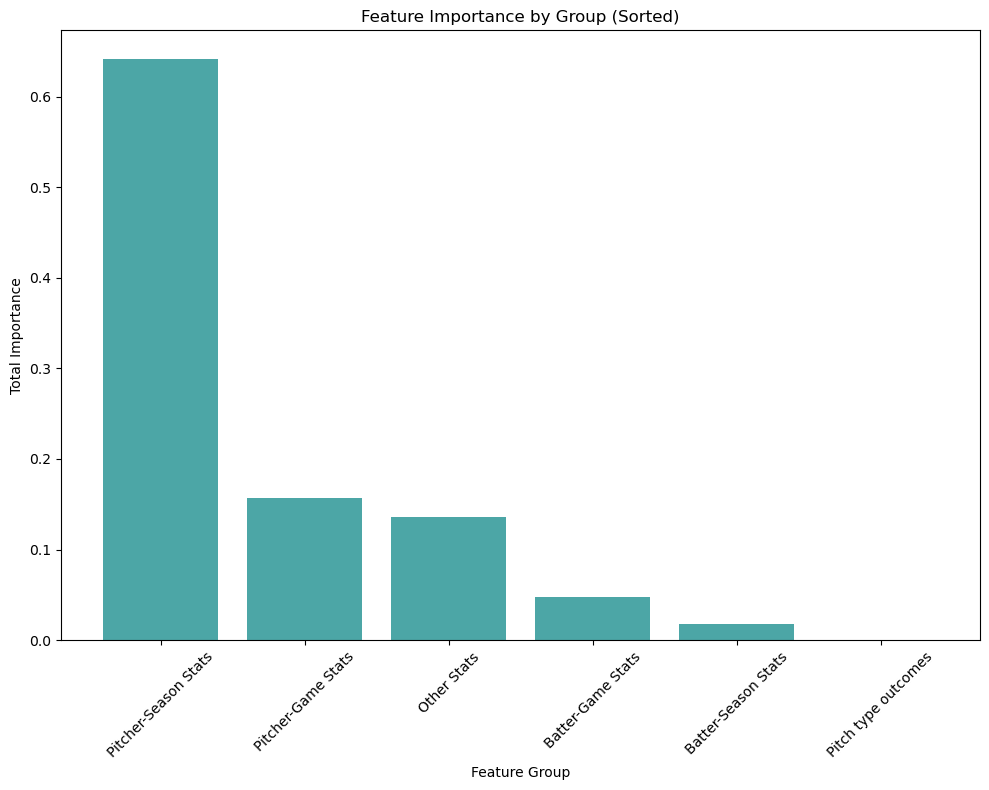

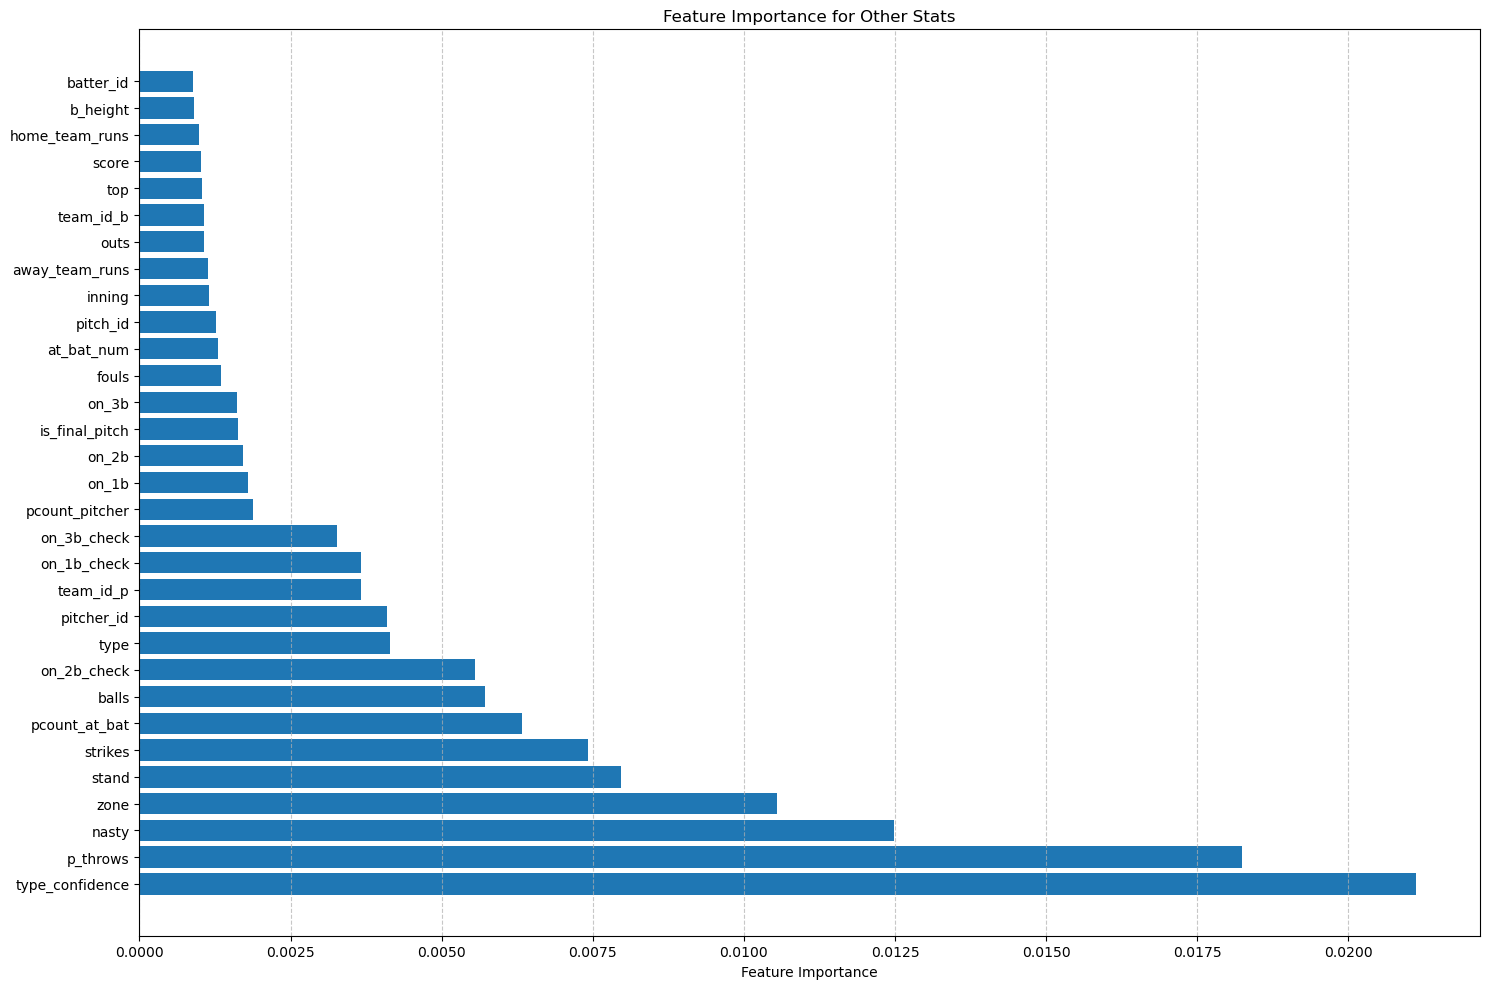

In [168]:
 visualize_results(model, X_test, y_test, pitch_type_encoder)

Our results are promising and show that the features we engineered were indeed significant.

Interestingly, "typical" criteria that most people's intuition might use to predict the next pitch — number of strikes, number of balls, score, and pitch count — matter relatively little compared to the general trends of a pitcher and batter. The most important of these is *p_throws* — the pitcher's throwing hand — which has an importance of about 0.018. In comparison, the pitcher-season stats stand out with an importance of over 0.6. Meanwhile, our engineered features for checking batters on the bases show moderate importance relative to these other criteria.



Another standard metric is the F1 score, which combines *precision* and *recall*.  
- *Precision* measures the proportion of correctly predicted positive instances out of all predicted positives.  
- *Recall* measures the proportion of actual positive instances correctly predicted by the model.

We display the following F1 scores:
- *Per-class F1 score*: The F1 score for each individual class (pitch type in this case).
- *Macro-average F1 score*: The average F1 score across all classes, treating each class equally.
- *Weighted-average F1 score*: The average F1 score across all classes, weighted by the number of true instances in each class.

Additionally, we display a *confusion matrix* to show where the model is predicting correctly and where it is making mistakes. This matrix helps to visualize how the model's predictions align with the actual labels for each class.

Class-wise Metrics:

AB (Class 0):
F1 Score: 0.0000
True Count: 0
Predicted Count: 0

CH (Class 1):
F1 Score: 0.4982
True Count: 14054
Predicted Count: 10428

CU (Class 2):
F1 Score: 0.6638
True Count: 11438
Predicted Count: 9802

EP (Class 3):
F1 Score: 0.1111
True Count: 33
Predicted Count: 3

FA (Class 4):
F1 Score: 0.2439
True Count: 66
Predicted Count: 16

FC (Class 5):
F1 Score: 0.5516
True Count: 8675
Predicted Count: 6563

FF (Class 6):
F1 Score: 0.7448
True Count: 49169
Predicted Count: 58364

FO (Class 7):
F1 Score: 0.5283
True Count: 34
Predicted Count: 19

FS (Class 8):
F1 Score: 0.6145
True Count: 2166
Predicted Count: 1691

FT (Class 9):
F1 Score: 0.6741
True Count: 16641
Predicted Count: 15668

IN (Class 10):
F1 Score: 0.9934
True Count: 907
Predicted Count: 917

KC (Class 11):
F1 Score: 0.5584
True Count: 1699
Predicted Count: 1385

KN (Class 12):
F1 Score: 0.8655
True Count: 773
Predicted Count: 863

PO (Class 13):
F1 Score: 0.9604
True Count: 104
Predicted Count: 98



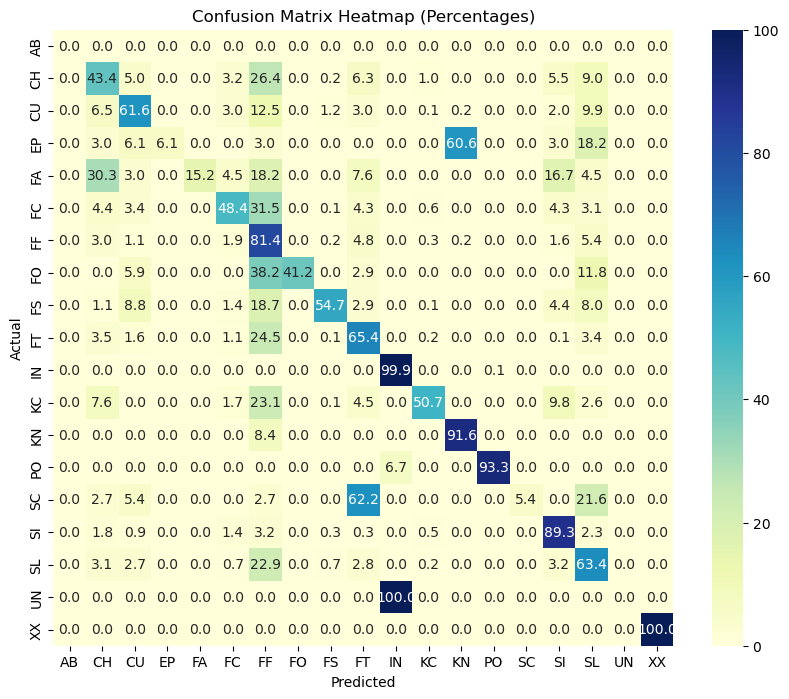

In [182]:
def get_f1(model, y_test, X_test, pitch_type_encoder):
    # Predict the labels
    y_pred = model.predict(X_test)
    
    # All possible classes
    all_classes = list(range(len(pitch_type_encoder.classes_)))
    
    # Calculate F1 scores
    per_class_f1 = f1_score(y_test, y_pred, average=None, labels=all_classes, zero_division=0)
    macro_f1 = f1_score(y_test, y_pred, average='macro', labels=all_classes, zero_division=0)
    weighted_f1 = f1_score(y_test, y_pred, average='weighted', labels=all_classes, zero_division=0)
    
    # Confusion matrix for true/predicted counts
    cm = confusion_matrix(y_test, y_pred, labels=all_classes)
    
    # Normalize the confusion matrix to percentages
    with np.errstate(divide='ignore', invalid='ignore'):
        cm_percentage = np.nan_to_num(cm.astype('float') / cm.sum(axis=1, keepdims=True) * 100)
    

    # Print class-wise metrics
    print("Class-wise Metrics:")
    for class_idx, pitch_type in enumerate(pitch_type_encoder.classes_):
        f1 = per_class_f1[class_idx]
        true_count = (y_test == class_idx).sum()
        pred_count = (y_pred == class_idx).sum()
        
        print(f"\n{pitch_type} (Class {class_idx}):")
        print(f"F1 Score: {f1:.4f}")
        print(f"True Count: {true_count}")
        print(f"Predicted Count: {pred_count}")
    
    print("\nOverall Metrics:")
    print(f"Macro F1: {macro_f1:.4f}")
    print(f"Weighted F1: {weighted_f1:.4f}")
    
    # Plot confusion matrix as heatmap (percentages)
    plt.figure(figsize=(10, 8))
    sns.heatmap(
        cm_percentage, 
        annot=True, 
        fmt='.1f', 
        cmap = 'YlGnBu',
        xticklabels=pitch_type_encoder.classes_, 
        yticklabels=pitch_type_encoder.classes_
    )
    plt.title("Confusion Matrix Heatmap (Percentages)")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()





get_f1(model=model, X_test=X_test, y_test=y_test, pitch_type_encoder = pitch_type_encoder)

We see that there are high marks on the diagonals, which means the model is making sound predictions. However, there is a moderate vertical line at *FF*.  This could indicate that the model defaults to guessing *FF* when it is not sure.

We also see some that some pitches with low F1 score occur very infrequently in the data (*AB*, *EP*, *FA*).  The model is having a hard time accurately predicting them because they occur so rarely in the dataset.

We can attempt to account for this by using *class weights*, biasing positively towards data that is rare, and biasing negatively against data that is overrepresented. We will run the model again with the same parameters, only using weights.

In [172]:
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = dict(zip(np.unique(y_train), class_weights))
sample_weight = np.array([class_weight_dict[label] for label in y_train])

model2 = xgb.XGBClassifier(
    objective='multi:softprob',
    eval_metric=['mlogloss', 'merror'],
    n_estimators=1000,
    learning_rate=0.1,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    device='cuda',
    early_stopping_rounds=20
)


# Fit
model2.fit(
    X_train, 
    y_train,
    eval_set=[(X_train, y_train), (X_test, y_test)],
    verbose=True,
    sample_weight =sample_weight
)

[0]	validation_0-mlogloss:2.70315	validation_0-merror:0.57425	validation_1-mlogloss:2.71362	validation_1-merror:0.58592
[1]	validation_0-mlogloss:2.51949	validation_0-merror:0.54269	validation_1-mlogloss:2.53542	validation_1-merror:0.55690
[2]	validation_0-mlogloss:2.38419	validation_0-merror:0.53735	validation_1-mlogloss:2.40247	validation_1-merror:0.55188
[3]	validation_0-mlogloss:2.27583	validation_0-merror:0.53572	validation_1-mlogloss:2.29527	validation_1-merror:0.55030
[4]	validation_0-mlogloss:2.18135	validation_0-merror:0.52903	validation_1-mlogloss:2.20207	validation_1-merror:0.54492
[5]	validation_0-mlogloss:2.09601	validation_0-merror:0.52548	validation_1-mlogloss:2.11802	validation_1-merror:0.54206
[6]	validation_0-mlogloss:2.02100	validation_0-merror:0.52100	validation_1-mlogloss:2.04365	validation_1-merror:0.53793
[7]	validation_0-mlogloss:1.95443	validation_0-merror:0.51815	validation_1-mlogloss:1.97792	validation_1-merror:0.53517
[8]	validation_0-mlogloss:1.89713	valida

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device='cuda', early_stopping_rounds=20,
              enable_categorical=False, eval_metric=['mlogloss', 'merror'],
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=1000,
              n_jobs=None, num_parallel_tree=None, objective='multi:softprob', ...)

XGBoost:
Accuracy: 0.6591
Log Loss: 0.8406

Mode Baseline:
Accuracy: 0.3419
Log Loss: 10.4910

Global Distribution:
Accuracy: 0.3419
Log Loss: 20.4420

Previous Pitch:
Accuracy: 0.3772
Log Loss: 9.9296

Pitcher-Season:
Accuracy: 0.4573
Log Loss: 1.3544

Pitcher-Game:
Accuracy: 0.4479
Log Loss: 2.2645

Batter-Season:
Accuracy: 0.3406
Log Loss: 1.9825

Batter-Game:
Accuracy: 0.3312
Log Loss: 4.5313

Random (theoretical):
Accuracy: 1/19 = 0.0526
Log loss: -ln(1/19)= 2.9444


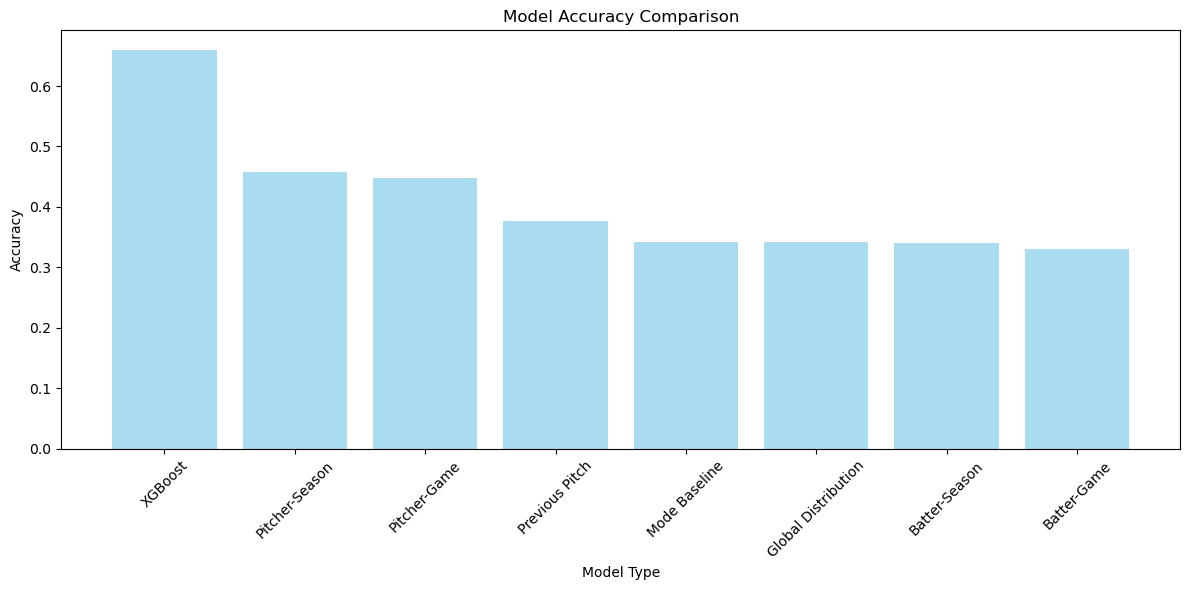

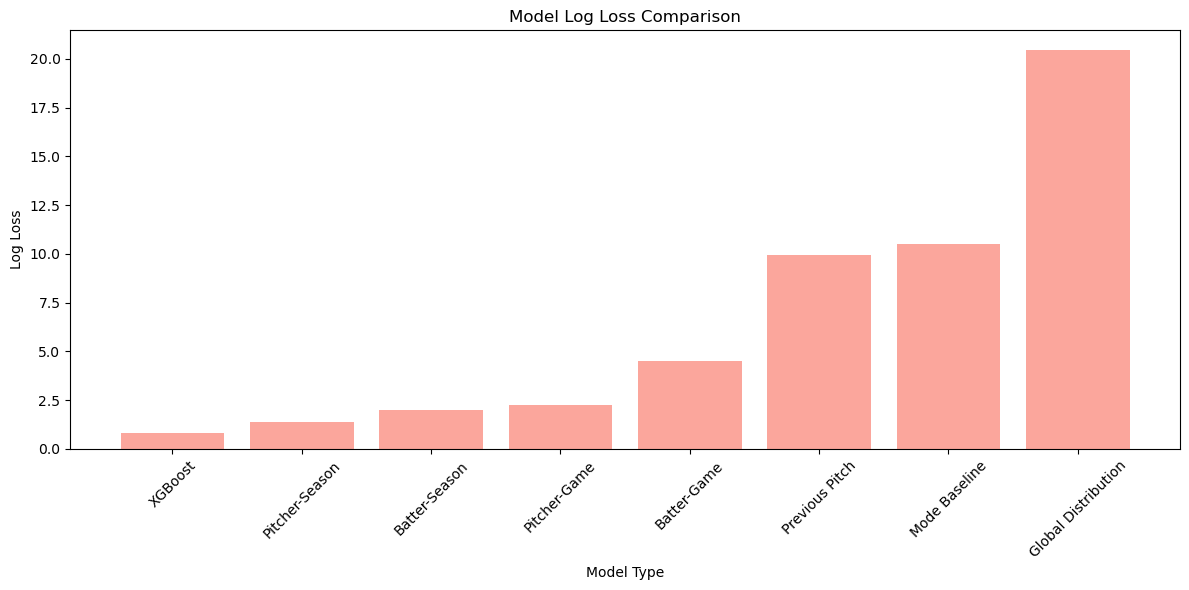

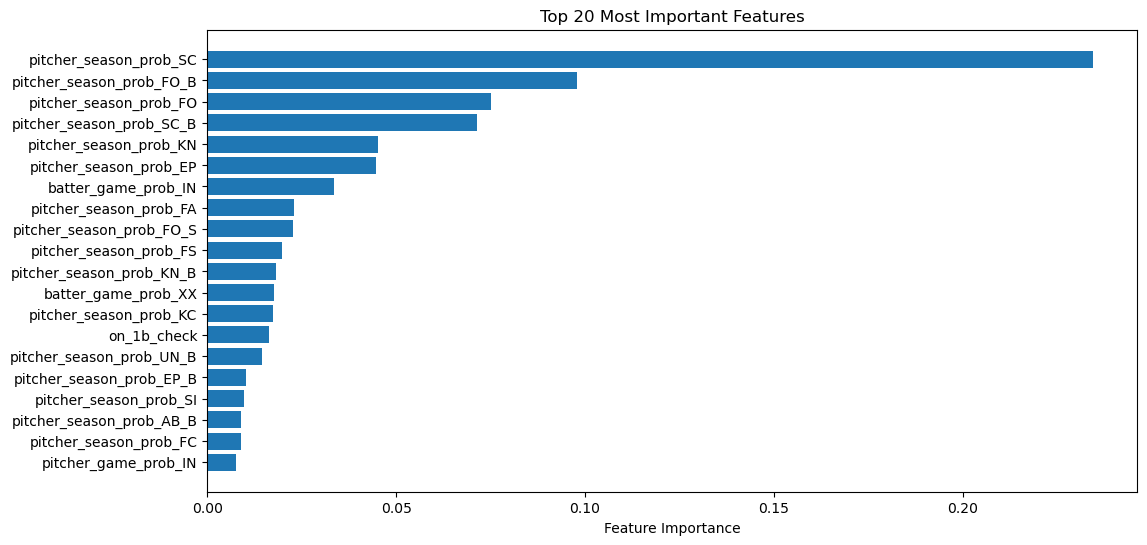

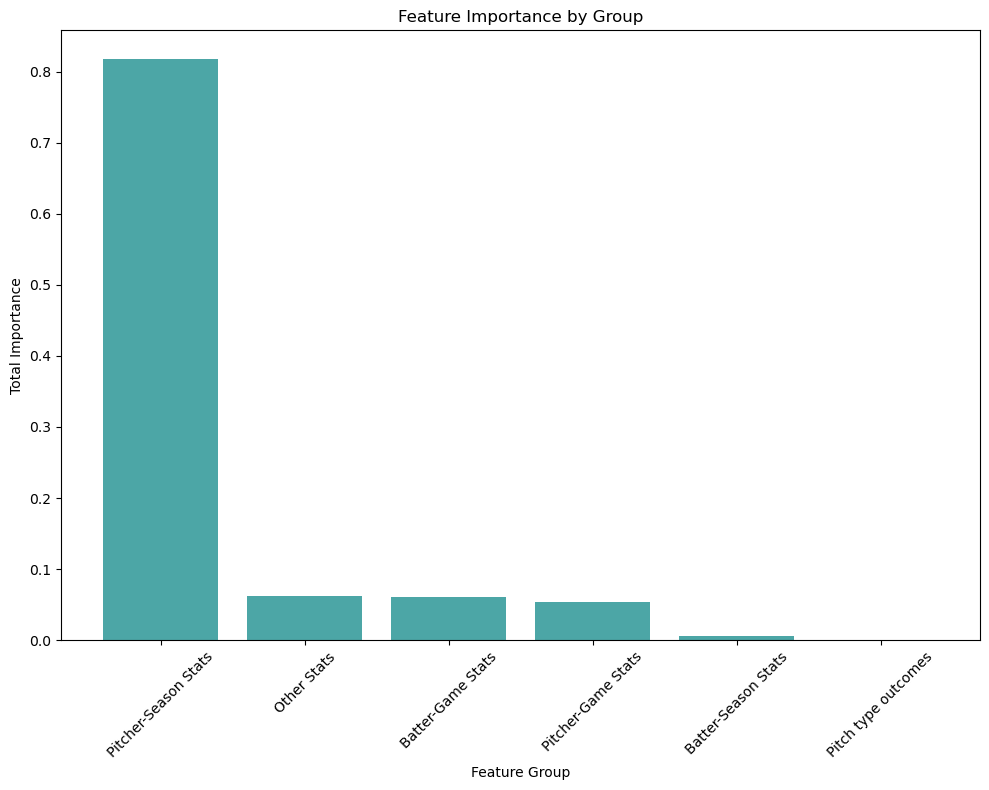

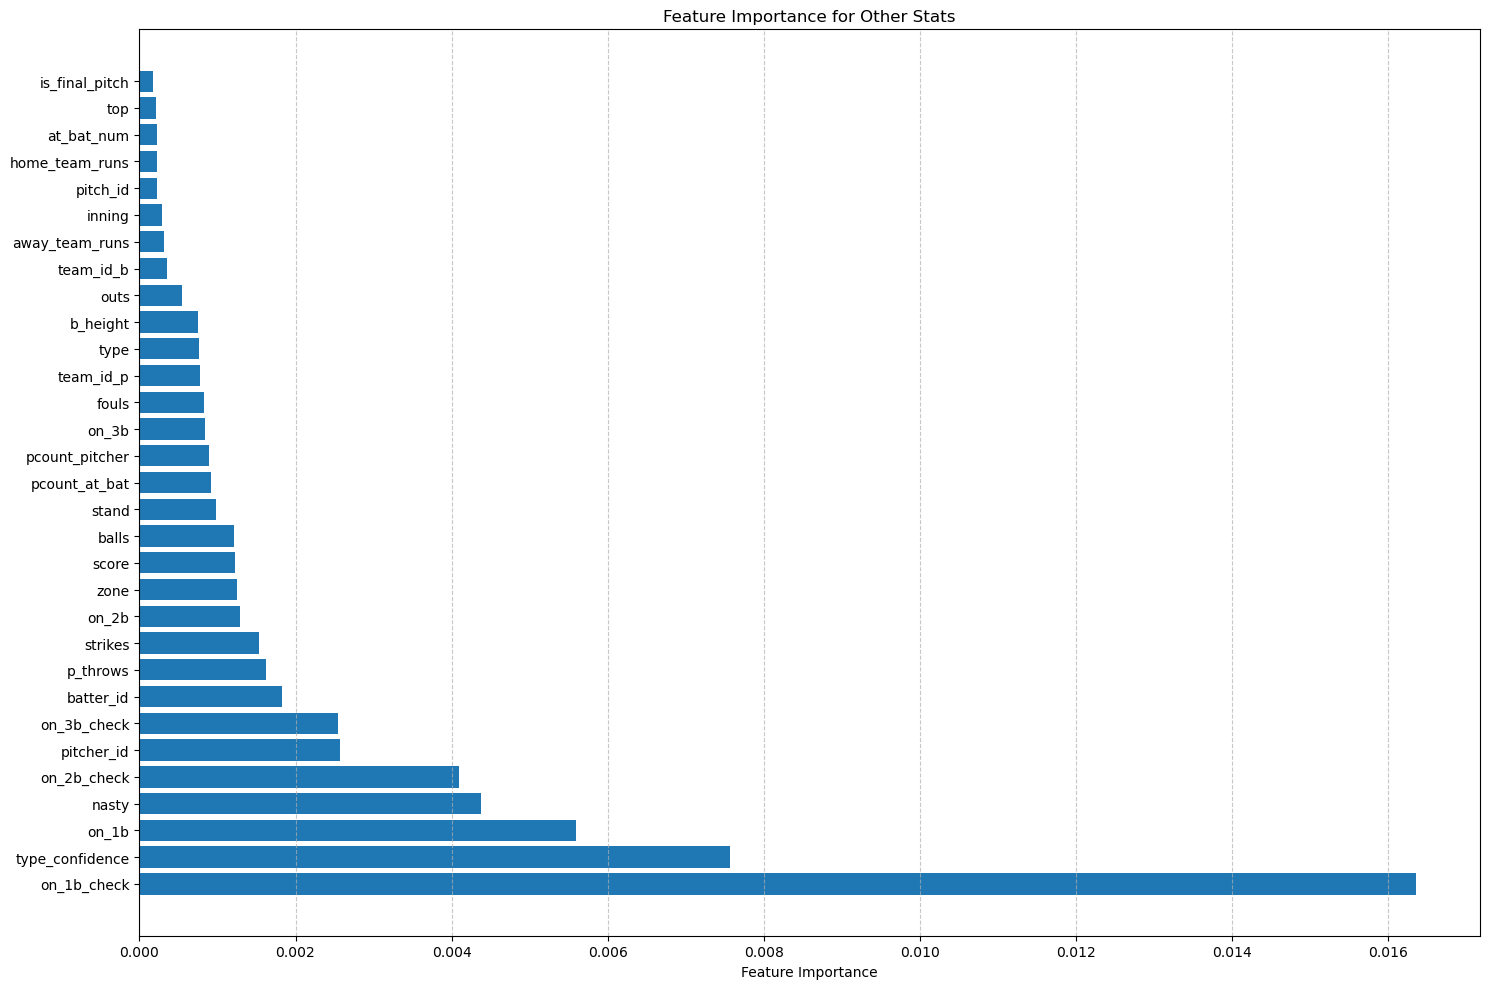

Class-wise Metrics:

AB (Class 0):
F1 Score: 0.0000
True Count: 0
Predicted Count: 0

CH (Class 1):
F1 Score: 0.5196
True Count: 14054
Predicted Count: 14716

CU (Class 2):
F1 Score: 0.6548
True Count: 11438
Predicted Count: 12824

EP (Class 3):
F1 Score: 0.1333
True Count: 33
Predicted Count: 12

FA (Class 4):
F1 Score: 0.2000
True Count: 66
Predicted Count: 14

FC (Class 5):
F1 Score: 0.5611
True Count: 8675
Predicted Count: 14729

FF (Class 6):
F1 Score: 0.6607
True Count: 49169
Predicted Count: 32508

FO (Class 7):
F1 Score: 0.5625
True Count: 34
Predicted Count: 30

FS (Class 8):
F1 Score: 0.5824
True Count: 2166
Predicted Count: 3789

FT (Class 9):
F1 Score: 0.6760
True Count: 16641
Predicted Count: 20430

IN (Class 10):
F1 Score: 0.9934
True Count: 907
Predicted Count: 917

KC (Class 11):
F1 Score: 0.5025
True Count: 1699
Predicted Count: 3993

KN (Class 12):
F1 Score: 0.8650
True Count: 773
Predicted Count: 894

PO (Class 13):
F1 Score: 0.9604
True Count: 104
Predicted Count: 9

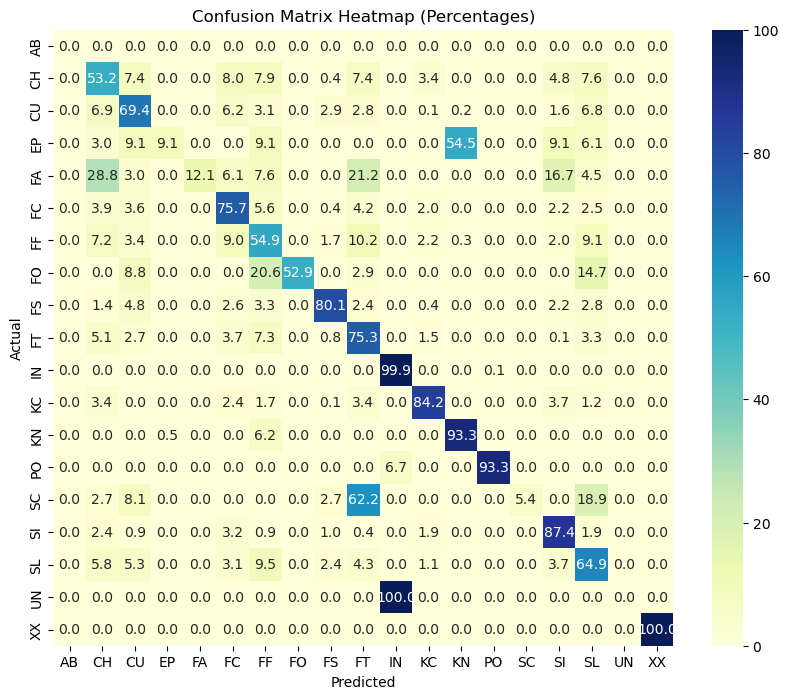

In [183]:
visualize_results(model=model2, X_data = X_test, y_data=y_test, pitch_type_encoder= pitch_type_encoder)
get_f1(model=model2, X_test=X_test, y_test=y_test, pitch_type_encoder = pitch_type_encoder)

The results are not substantial.  

Now:
- *Macro F1*: 0.5507
- *Weighted F1*: 0.6621
- *Accuracy*: 0.6591
- *Log Loss*: 0.8406

Before:
- *Macro F1*: 0.5587
- *Weighted F1*: 0.6914
- *Accuracy*: 0.6984
- *Log Loss*: 0.7648


The F1 scores and accuracy did not change much, and log loss got a little worse.  On the one hand, we got rid of the vertical line at *FF*. This was also our most significant change in F1 score, with 0.7748 before and 0.6607 now.  It may seem strange that the erroneous vertical line disappeared, yet the F1 score got worse.  While the off diagonal entries happily decreased, so did the diagonal entry.  We misidentify *FF* less frequently, but we also simultaneously fail to correctly identify *FF* more frequently. This weighting process washes out the differences between the pitches, as expected, but does not yield exceptionally different results.

Quite interestingly, if we look at the feature importance for the weight-adjusted model, the most important feature by a factor of two is the first base check *on_1b_check* we engineered. The next most important is type confidence, which is an artificial measure, followed by the identity of the runner on first base. *on_2b_check* and *on_3b_check* are not far behind. It seems that base runners are of utmost importance when predicting the next pitch.

To improve further on this model, we could continue with hyperparameter optimization with random search. We have just chosen one set of parameters for our XGBoost model, and we should try more.

In the end, a pitcher’s past throws proved the most predictive. Unsurprisingly, previous pitch probabilities are the best guide to predicting the next pitch.